# Poincare Boundary Condition

Most of the tutorials use last closed flux surface (LCFS) as the boundary condition for 3D equilibrium. This tutorial will cover another way to define boundary condition using DESC.

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

If you have access to a GPU, uncomment the following two lines. 

In [ ]:
# from desc import set_device

# set_device("gpu")

In [3]:
%matplotlib inline
import numpy as np

from desc.io import load
from desc.grid import LinearGrid
from desc.objectives import (
    ObjectiveFunction,
    ForceBalance,
    FixSectionLambda,
    FixSectionR,
    FixSectionZ,
    FixPressure,
    FixPsi,
    FixIota,
    QuasisymmetryTwoTerm,
    get_fixed_xsection_constraints,
    get_fixed_boundary_constraints,
)
from desc.examples import get
from desc.plotting import *
from desc.geometry import ZernikeRZToroidalSection
from desc.equilibrium import Equilibrium
from desc.backend import print_backend_info

print_backend_info()

DESC version=0.14.1+360.gfb9527a55.dirty.
Using JAX backend: jax version=0.5.0, jaxlib version=0.5.0, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 10.78 GB available memory.


### Solving Poincare Boundary Condition from an existing equilibrium

To first show that Poincare BC gives the same result with LCFS for not highly shaped plasma, let's set our optimization problem by taking the $\zeta$=0 Poincare cross-section of Heliotron equilibrium.

**Note:** We should emphasize that this method is shown to work for plasma with **minor** shaping. We see that optimization gets harder for highly shaped plasma (cross-sections differ substantially around toroidal direction, like `precise_QA` or `W7-X`). Further in the notebook, we will see that one reason of this is our initial guess being axisymmetric, when we warm start using the existing shaped plasma, optimization can converge to similar flux surfaces.

In [4]:
def set_poincare_equilibrium(eq):
    eq_poincare = Equilibrium(
        xsection=eq.get_surface_at(zeta=0),
        pressure=eq.pressure,
        iota=eq.iota,
        Psi=eq.Psi,  # flux (in Webers) within the last closed flux surface
        NFP=eq.NFP,  # number of field periods
        L=eq.L,  # radial spectral resolution
        M=eq.M,  # poloidal spectral resolution
        N=eq.N,  # toroidal spectral resolution
        L_grid=eq.L_grid,  # real space radial resolution, slightly oversampled
        M_grid=eq.M_grid,  # real space poloidal resolution, slightly oversampled
        N_grid=eq.N_grid,  # real space toroidal resolution
        sym=eq.sym,  # explicitly enforce stellarator symmetry
        spectral_indexing=eq._spectral_indexing,
    )

    eq_poincare.change_resolution(eq.L, eq.M, eq.N)
    eq_poincare.axis = eq_poincare.get_axis()
    eq_poincare.surface = eq_poincare.get_surface_at(rho=1)
    return eq_poincare

In [5]:
eq = get("HELIOTRON")

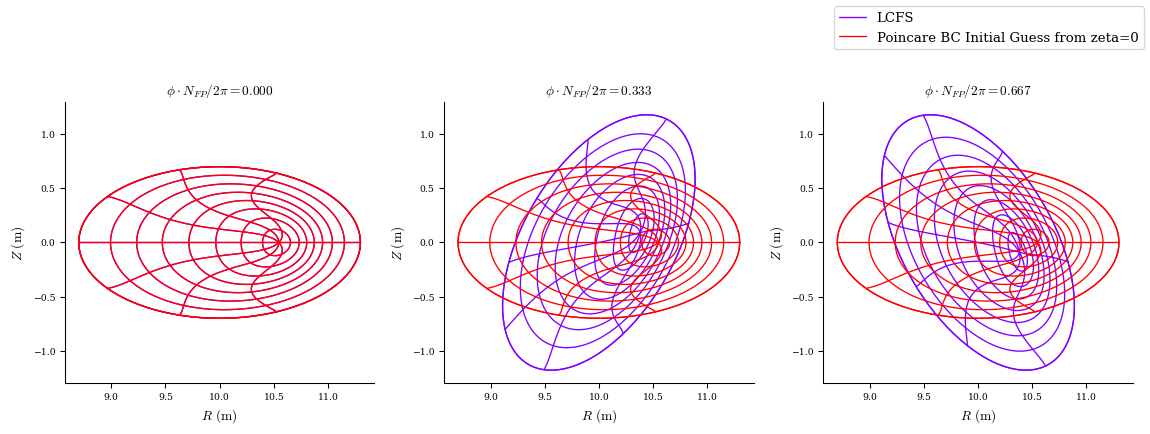

In [11]:
eq_poin = set_poincare_equilibrium(eq)
plot_comparison(
    eqs=[eq, eq_poin], phi=3, labels=["LCFS", f"Poincare BC Initial Guess from zeta=0"]
);

Now, we can solve the newly created `eq_poin` as usual. The code will apply some checks to see if you are trying to solve a Poincare BC problem or LCFS. Then, add the required constraints and objectives before sending it to the optimizer.

In [12]:
eq_poin = set_poincare_equilibrium(eq)  # zeta=0 surface will be fixed
for N in range(1, eq.N + 1):
    print(f"\n\nSolving for N={N}...\n\n")
    eq_poin.change_resolution(N=N, N_grid=2 * N)

    constraints = get_fixed_xsection_constraints(eq=eq_poin)
    objective = ObjectiveFunction(ForceBalance(eq_poin))

    eq_poin.solve(
        verbose=3,
        objective=objective,
        constraints=constraints,
        maxiter=75,
        ftol=1e-3,
    );



Solving for N=1...


Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 75.4 ms
Timer: Objective build = 84.0 ms
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed cross-section λ
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section λ
Timer: Objective build = 94.4 ms
Timer: LinearConstraintProjection build = 2.83 sec
Number of parameters: 507
Number of objectives: 1900
Timer: Initializing the optimization = 3.03 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
      

A user cannot fix both LCFS and Poincare section variables, `(Rb_lmn, Zb_lmn)` and `(Rp_lmn, Zp_lmn, Lp_lmn)` respectively. For this reason, DESC sets `(Rb_lmn, Zb_lmn)` as non-optimizable which makes the `eq.surface` attribute inconsistent with the actual surface. For now, we expect the user to set the surface manually to proper value by,

In [18]:
eq_poin.surface = eq_poin.get_surface_at(rho=1)

Similarly, when a user don't use the Poincare variables (such that `FixSection...` or `get_fixed_xsection_constraints` is not called at all), `eq.xsection` will not be consistent with the actual $\zeta=0$ cross-section. We will probably automize this in future.

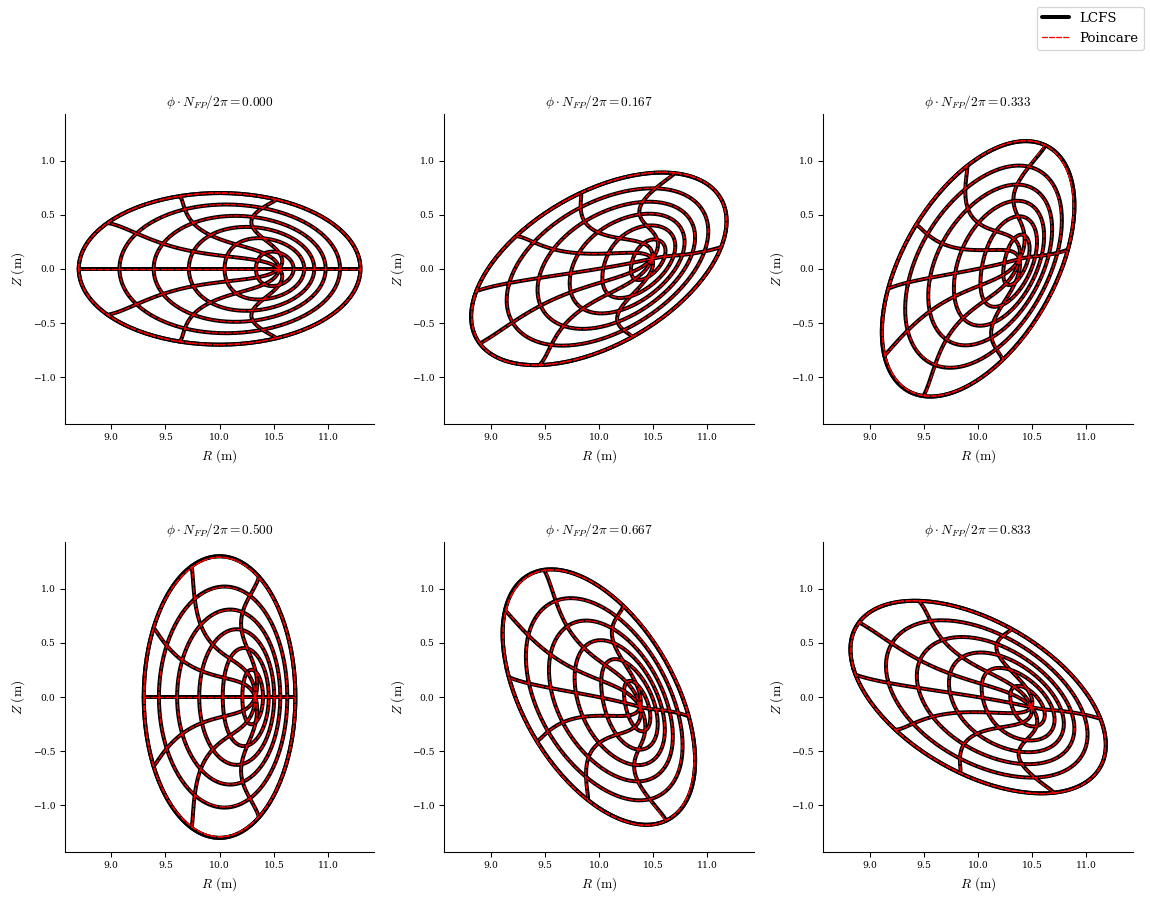

In [13]:
plot_comparison(
    eqs=[eq, eq_poin],
    rho=6,
    labels=["LCFS", "Poincare"],
    ls=["-", "--"],
    lw=[3, 1],
    color=["k", "r"],
);

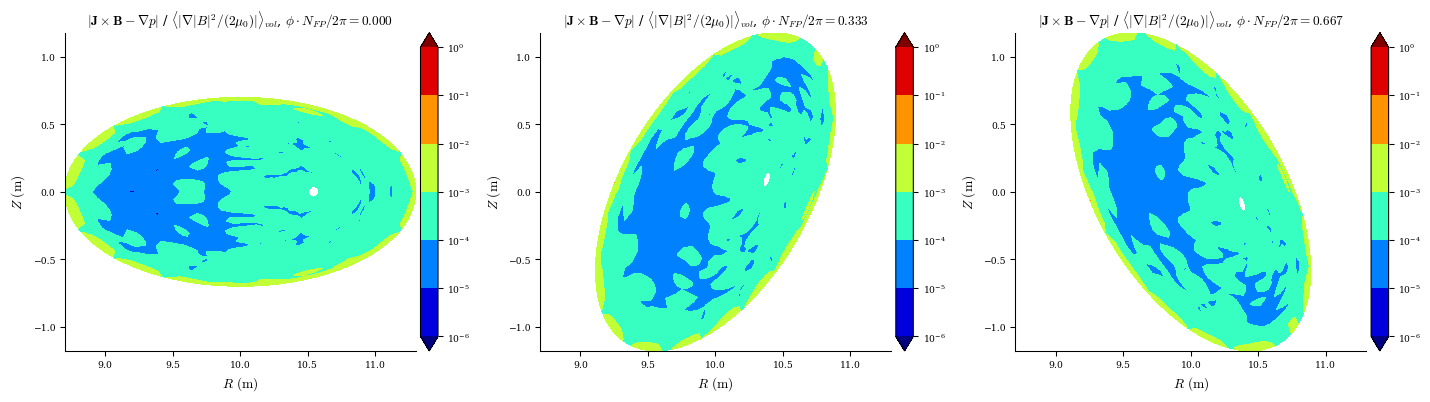

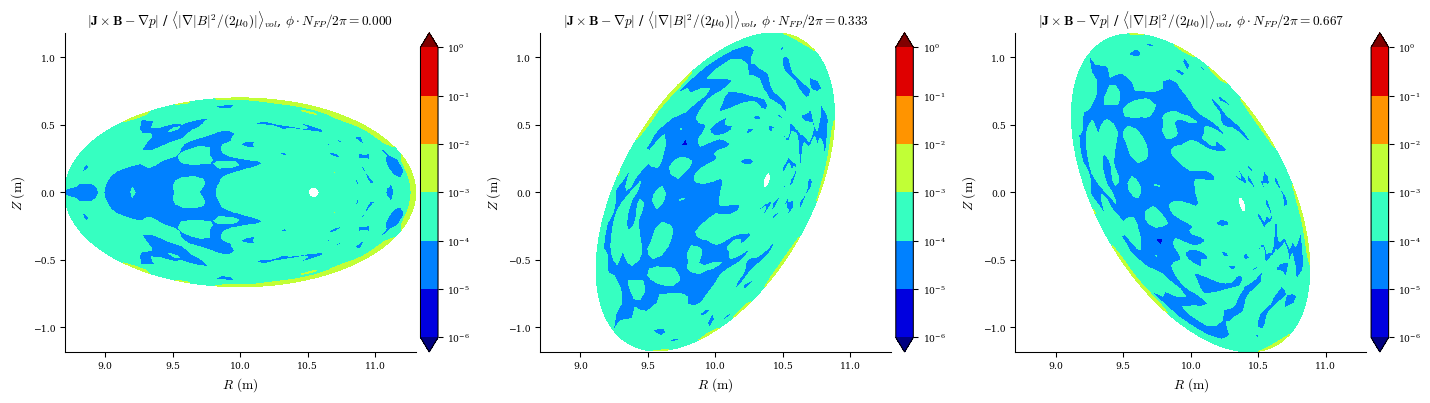

In [14]:
plot_section(eq, "|F|", phi=3, norm_F=True, log=True)
plot_section(eq_poin, "|F|", phi=3, norm_F=True, log=True);

We can see that especially around the last closed flux surface, the final equilibrium obtained by Poincare boundary condition has lower force error. This property can be used to reduce the force balance error of an existing equilibrium. Below, it can be seen that the volume averaged normalized force error is also lower for `eq_poin`.

In [15]:
f1 = (
    eq.compute("<|F|>_vol")["<|F|>_vol"]
    / eq.compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)
f2 = (
    eq_poin.compute("<|F|>_vol")["<|F|>_vol"]
    / eq_poin.compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)
print(f"Force error eq_lcfs: {f1:.4e}")
print(f"Force error eq_poin: {f2:.4e}")

Force error eq_lcfs: 3.0407e-04
Force error eq_poin: 1.8594e-04


### Creating a new Poincare surface to fix 

We can also create a new surface object called `ZernikeRZToroidalSection` to set our optimization problem as LCFS.

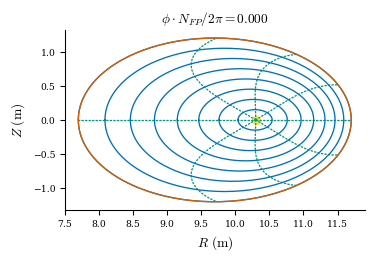

In [16]:
R_lmn = np.array([10, -2, -0.3])
modes_R = np.array([[0, 0], [1, 1], [2, 0]])

Z_lmn = np.array([1.2])
modes_Z = np.array([[1, -1]])

L_lmn = np.array([-0.6, -0.2])
modes_L = np.array([[1, -1], [3, -1]])

section = ZernikeRZToroidalSection(
    R_lmn=R_lmn,
    modes_R=modes_R,
    Z_lmn=Z_lmn,
    modes_Z=modes_Z,
    L_lmn=L_lmn,
    modes_L=modes_L,
)

eq_poincare = Equilibrium(
    xsection=section,
    Psi=eq.Psi,  # flux (in Webers) within the last closed flux surface
    pressure=0,
    iota=0,
    NFP=10,  # number of field periods
    L=5,  # radial spectral resolution
    M=5,  # poloidal spectral resolution
    N=3,  # toroidal spectral resolution
    L_grid=eq.L_grid,  # real space radial resolution, slightly oversampled
    M_grid=eq.M_grid,  # real space poloidal resolution, slightly oversampled
    N_grid=eq.N_grid,  # real space toroidal resolution
    sym=True,  # explicitly enforce stellarator symmetry
    spectral_indexing=eq._spectral_indexing,
)

plot_surfaces(eq_poincare, phi=1);

## Using Poincare Boundary Condition to reduce Force Error around the LCFS

As we mentioned above, the equilibrium solved by Poincare boundary condition has lower force error around the LCFS. We can use this procedure to relax the last closed flux surface parameters, and obtain a better equilibrium close to the original equilibrium.

Let's use W7-X example.

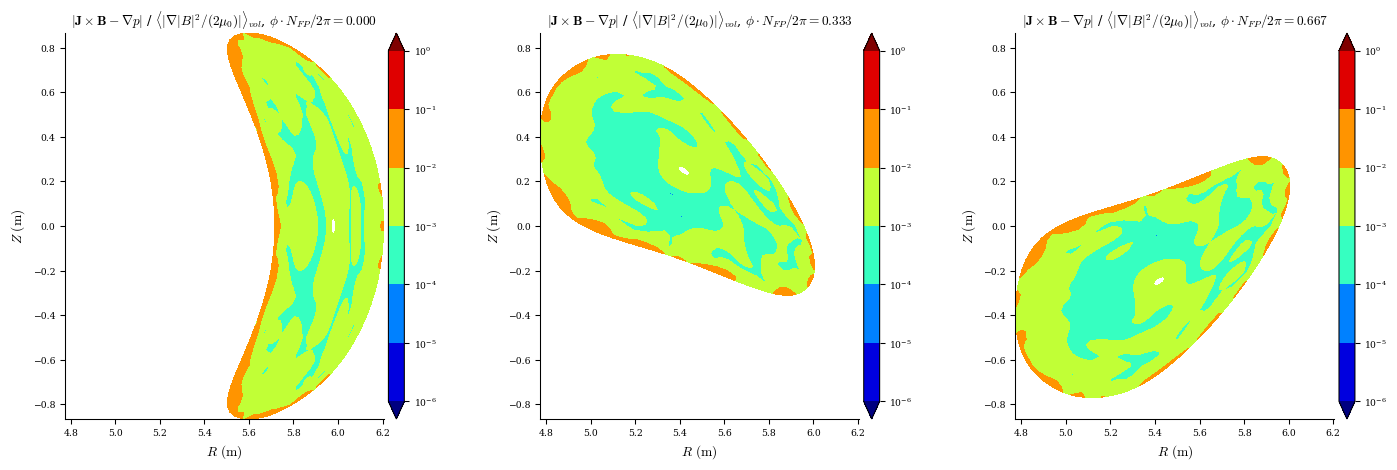

In [19]:
eq0 = get("W7-X")
plot_section(eq0, "|F|", phi=3, norm_F=True, log=True);

This time, we will use the `get_fixed_xsection_constraints` function with `fix_lambda=False`. We can also use the default `fix_lambda=True` but by not fixing the lambda, we add an additional freedom to improve the force balance at the fixed cross-section, too. We didn't use this approach above to save time, since more optimizable parameters increase the size of the Jacobian and makes every computation slower. Our initial equilibrium is already in a good force balance, therefore the new solve won't take too long, and we accept slower iterations.

In [20]:
eq = eq0.copy()
constraints = get_fixed_xsection_constraints(eq=eq, fix_lambda=False)
objective = ObjectiveFunction(ForceBalance(eq))

eq.solve(
    verbose=3,
    objective=objective,
    constraints=constraints,
    maxiter=50,
);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 669 ms
Timer: Objective build = 872 ms
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section λ
Timer: Objective build = 408 ms
Timer: LinearConstraintProjection build = 4.26 sec
Number of parameters: 3318
Number of objectives: 5346
Timer: Initializing the optimization = 6.08 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          5.653e-07                               

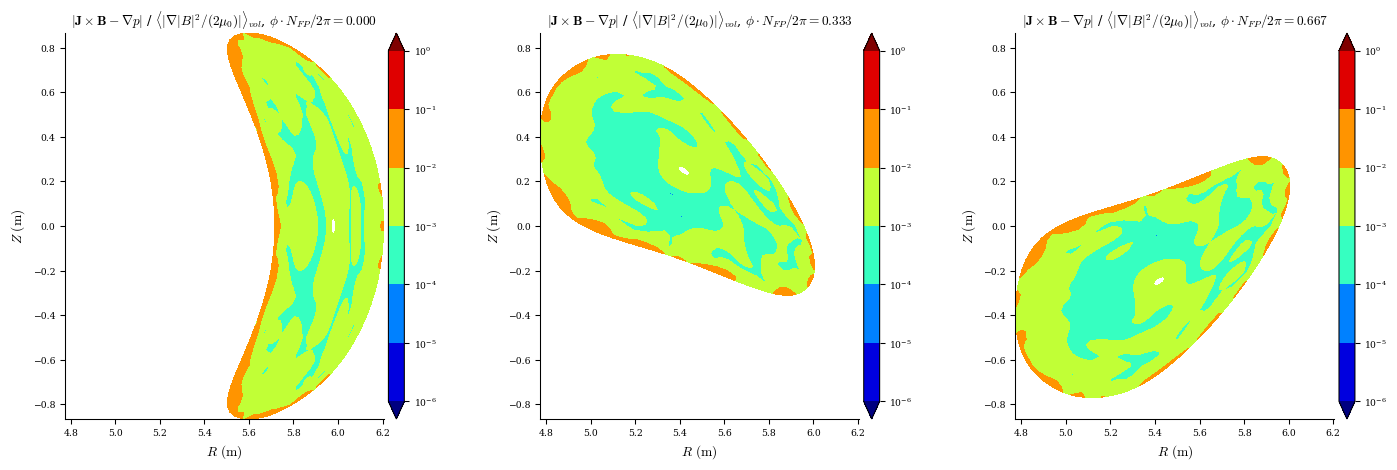

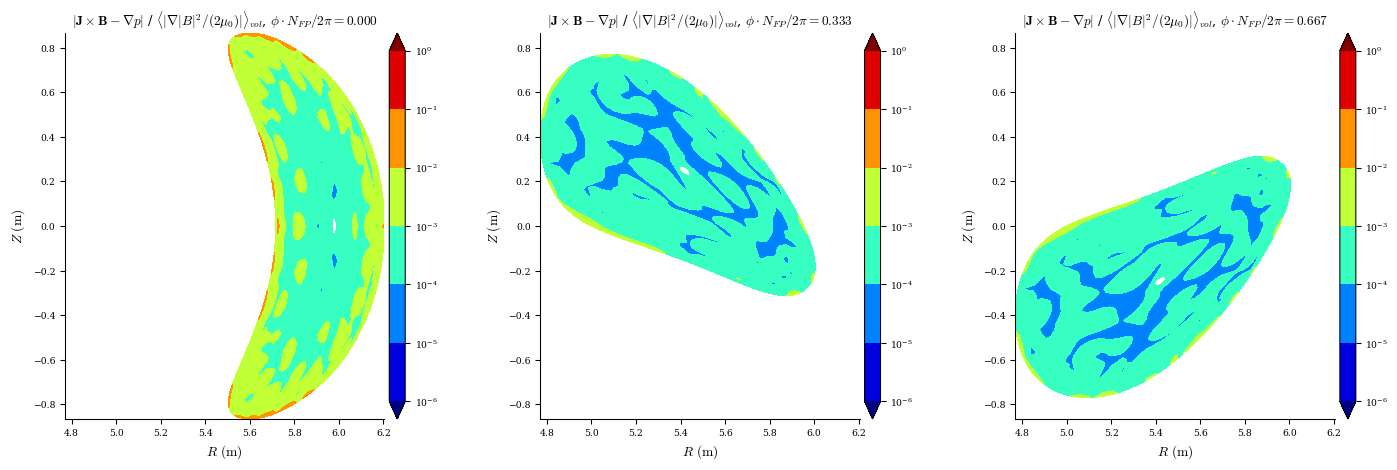

In [21]:
plot_section(eq0, "|F|", phi=3, norm_F=True, log=True)
plot_section(eq, "|F|", phi=3, norm_F=True, log=True);

In [22]:
f1 = (
    eq0.compute("<|F|>_vol")["<|F|>_vol"]
    / eq0.compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)
f2 = (
    eq.compute("<|F|>_vol")["<|F|>_vol"]
    / eq.compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)
print(f"Force error eq_lcfs: {f1:.4e}")
print(f"Force error eq_poin: {f2:.4e}")

Force error eq_lcfs: 2.8639e-03
Force error eq_poin: 3.2854e-04


As expected, we got a much better force equilibrium. And as it can be seen from the next figure, this is achieved by minor changes to the last closed flux surface shape.

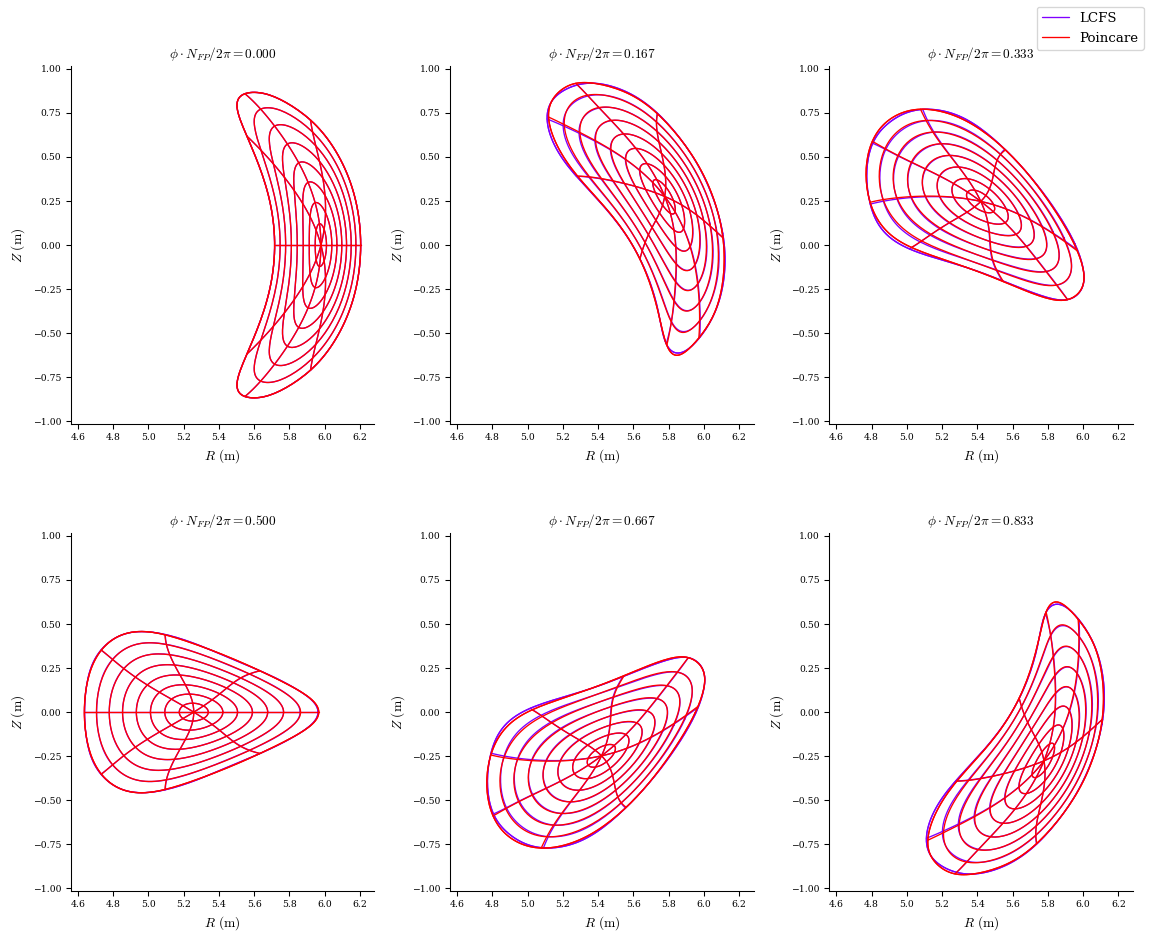

In [23]:
plot_comparison(eqs=[eq0, eq], labels=["LCFS", "Poincare"]);

One can use the reverse strategy to improve the force balance error of the final equilibrium around the fixed cross-section, and get a much better equilibrium otherwise very hard to get (even with extermely small stopping tolerances for the optimizer).

## Optimization with Poincare Solve

**Note**: I added this section to discuss eligibility of Poincare solve for optimization. The result is pretty bad in this state.

During equilibrium optimization, if a user gives `ForceBalance` as constraint, DESC automatically uses `proximal-lsq-exact` which solve the equilibrium at each optimization step to preserve the MHD force balance. This internal equilibrium solve use fixed-boundary constraint by default. However, this can be changed to fixed-Poincare section solve, if user adds one of the `FixSection...` constraints instead of `FixBoundary...` constraints. Let's see an example!

We will conduct a similar optimization as shown in [Basic QS Optimization](https://desc-docs.readthedocs.io/en/latest/notebooks/tutorials/basic_optimization.html) notebook.

In [5]:
from desc.io import load

eq_init = load("qs_initial_guess.h5")
eq_init.xsection = eq_init.get_surface_at(zeta=0)
# put this Equilibrium into ForceBalance according to the Poincare Section standards
constraints = get_fixed_xsection_constraints(eq=eq_init)
objective = ObjectiveFunction(ForceBalance(eq_init))

eq_init.solve(
    verbose=3,
    objective=objective,
    constraints=constraints,
    maxiter=50,
)
eq_init.xsection = eq_init.get_surface_at(zeta=0)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 787 ms
Timer: Objective build = 1.17 sec
Building objective: fixed cross-section R
Building objective: fixed cross-section Z
Building objective: fixed cross-section λ
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Building objective: self_consistency section R
Building objective: self_consistency section Z
Building objective: self_consistency section λ
Timer: Objective build = 414 ms
Timer: LinearConstraintProjection build = 4.69 sec
Number of parameters: 540
Number of objectives: 2754
Timer: Initializing the optimization = 6.38 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1       

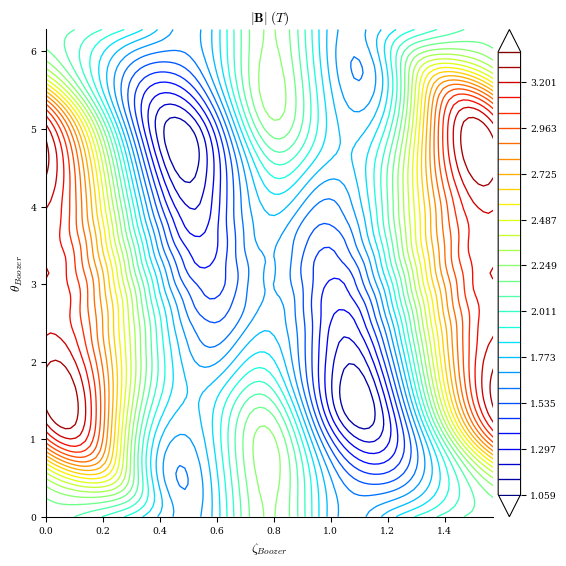

In [6]:
# plot |B| contours in Boozer coordinates on a surface (default is rho=1)
plot_boozer_surface(eq_init);

In [7]:
# boundary modes to constrain
R_modes = np.vstack(
    (
        [0, 0, 0],
        eq_init.xsection.R_basis.modes[
            np.max(np.abs(eq_init.xsection.R_basis.modes), 1) > 1, :
        ],
    )
)
Z_modes = eq_init.xsection.Z_basis.modes[
    np.max(np.abs(eq_init.xsection.Z_basis.modes), 1) > 1, :
]

eq_qs_T = eq_init.copy()  # make a copy of the original one
# constraints
constraints = (
    ForceBalance(eq=eq_qs_T),  # enforce JxB-grad(p)=0 during optimization
    FixSectionR(eq=eq_qs_T, modes=R_modes),  # fix specified R boundary modes
    FixSectionZ(eq=eq_qs_T, modes=Z_modes),  # fix specified Z boundary modes
    FixPressure(eq=eq_qs_T),  # fix pressure profile
    FixIota(eq=eq_qs_T),  # fix rotational transform profile
    FixPsi(eq=eq_qs_T),  # fix total toroidal magnetic flux
)

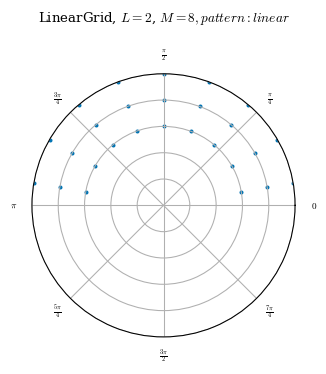

In [10]:
# objective
grid = LinearGrid(
    M=eq_qs_T.M, N=eq_qs_T.N, NFP=eq_qs_T.NFP, rho=np.array([0.6, 0.8, 1.0]), sym=True
)
plot_grid(grid)

objective_fT = ObjectiveFunction(
    QuasisymmetryTwoTerm(eq=eq_qs_T, helicity=(0, 1), grid=grid, normalize=False)
)

In [15]:
eq_qs_T, result_T = eq_qs_T.optimize(
    objective=objective_fT,
    constraints=constraints,
    ftol=5e-2,  # stopping tolerance on the function value
    xtol=1e-6,  # stopping tolerance on the step size
    gtol=1e-6,  # stopping tolerance on the gradient
    maxiter=50,  # maximum number of iterations
    options={
        "solve_options": {
            "ftol": 5e-3,
            "xtol": 1e-6,
            "gtol": 1e-6,
            "verbose": 3,
        },  # for equilibrium subproblem
        # sometimes the default initial trust radius is too big, allowing the
        # optimizer to take too large a step in a bad direction. If this happens,
        # we can manually specify a smaller starting radius.
        # "initial_trust_radius": 1,
    },
    copy=False,  # copy=False we will overwrite the eq_qs_T object with the optimized result
    verbose=3,
)

Timer: Objective build = 1.14 ms
Timer: Objective build = 1.23 ms
Timer: Eq Update LinearConstraintProjection build = 207 ms
Timer: Proximal projection build = 1.11 sec
Timer: Objective build = 1.28 ms
Timer: LinearConstraintProjection build = 236 ms
Number of parameters: 22
Number of objectives: 243
Timer: Initializing the optimization = 1.42 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          1.055e+03                                    4.095e+01   
Number of parameters: 540
Number of objectives: 2754
Timer: Initializing the optimization = 7.85 ms

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          6.797e-03                                    5.014e-02   
       1              2          1.666e-03      5.131e-03      1.355e-01      2.676

(<Figure size 576.113x576.113 with 2 Axes>,
 <Axes: title={'center': '$|\\mathbf{B}|~(T)$'}, xlabel='$\\zeta_{Boozer}$', ylabel='$\\theta_{Boozer}$'>)

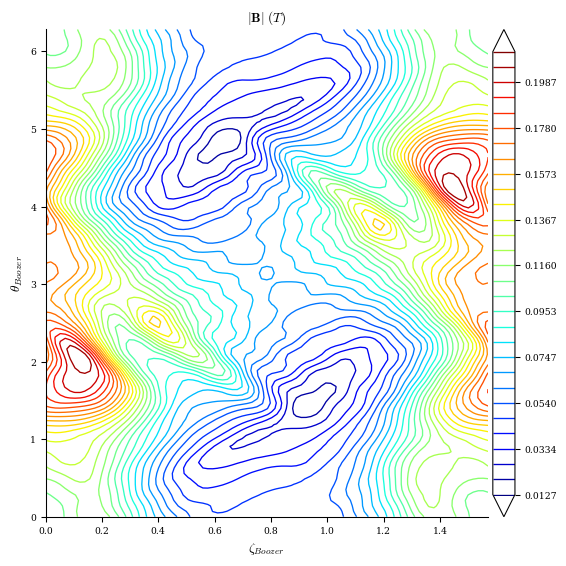

In [16]:
# |B| contours at rho=1 surface
plot_boozer_surface(eq_qs_T)

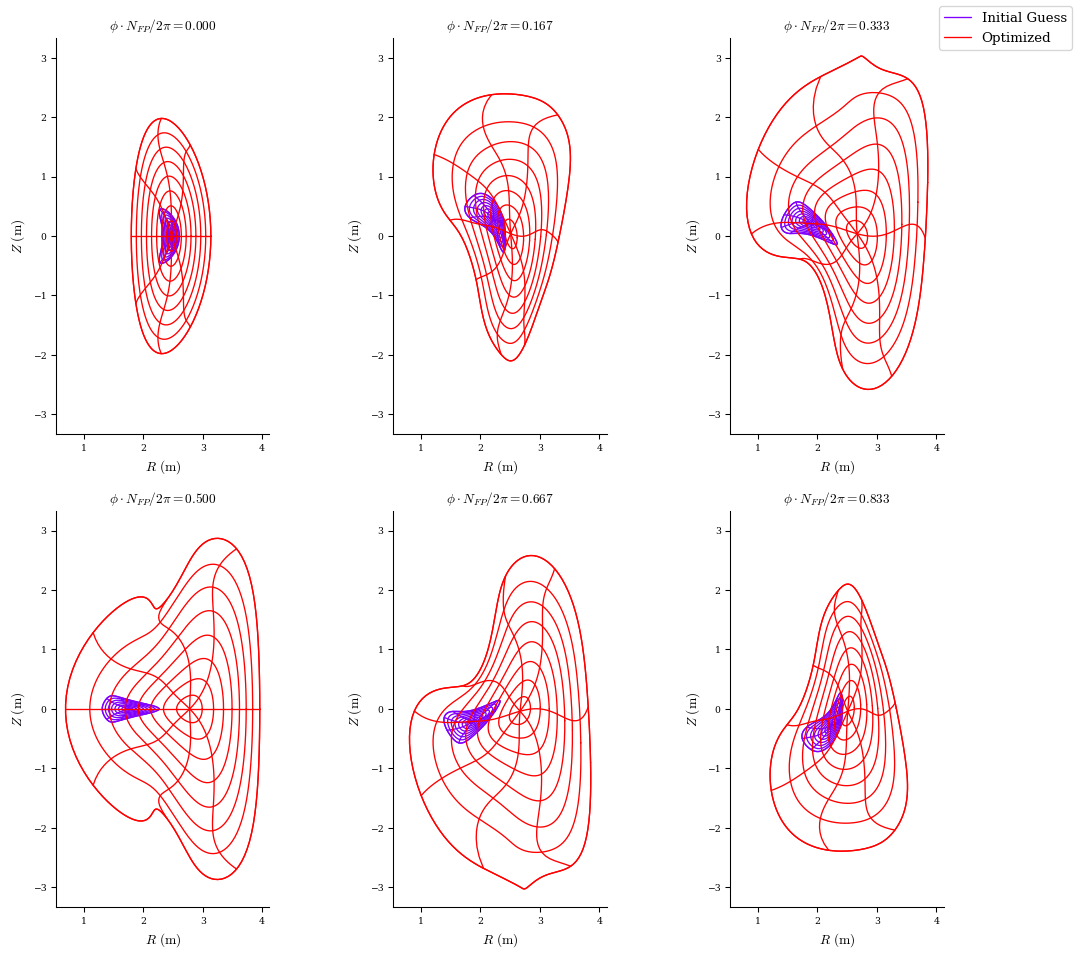

In [17]:
plot_comparison(eqs=[eq_init, eq_qs_T], labels=["Initial Guess", "Optimized"]);